In [4]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.4/150.0 MB 22.5 MB/s eta 0:00:07
   -- ------------------------------------- 10.0/150.0 MB 28.3 MB/s eta 0:00:05
   ---- ----------------------------------- 16.5/150.0 MB 28.9 MB/s eta 0:00:05
   ------ --------------------------------- 23.3/150.0 MB 29.5 MB/s eta 0:00:05
   ------- -------------------------------- 29.9/150.0 MB 30.6 MB/s eta 0:00:04
   --------- ------------------------------ 35.1/150.0 MB 30.6 MB/s eta 0:00:04
   ---------- ----------------------------- 40.1/150.0 MB 28.3 MB/s eta 0:00:04
   ------------ --------------------------- 47.4/150.0 MB 29.0 MB/s eta 0:00:04
   -------------- ------------------------- 54.8/150.0 MB 29.8 MB/s eta 0:00:04
   ---------------- ----------------------- 61.1/150.0 MB 29.9 MB/s eta 0:00:03
   ----------------- ---------------------- 67.4/150.0 MB 30.0 MB/s eta 0:00:03
   ------------------- -------------------- 74.2/1

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew


In [31]:
#Load cleaned dataset

df = pd.read_csv("bank_balanced.csv", delimiter = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,34,services,married,secondary,no,1076,no,no,cellular,12,may,152,1,182,6,success,yes
1,27,technician,single,secondary,no,2,yes,yes,cellular,6,may,554,2,356,1,failure,yes
2,30,admin.,single,secondary,no,270,no,no,cellular,30,apr,437,1,80,1,success,yes
3,28,technician,single,unknown,no,0,yes,no,cellular,27,oct,96,1,267,1,failure,yes
4,30,student,single,tertiary,no,2539,no,no,telephone,5,mar,199,5,-1,0,unknown,yes


In [32]:
# Change categorical to numerical values by encoding 
df['y']= df['y'].map({'yes':1, 'no':0})

In [33]:
df['y']

0        1
1        1
2        1
3        1
4        1
        ..
10573    1
10574    0
10575    1
10576    0
10577    1
Name: y, Length: 10578, dtype: int64


Outliers in column 'age':
Number of outliers: 162
Percentage of outliers: 1.53%

Outliers in column 'balance':
Number of outliers: 1019
Percentage of outliers: 9.63%

Outliers in column 'duration':
Number of outliers: 559
Percentage of outliers: 5.28%

Outliers in column 'campaign':
Number of outliers: 551
Percentage of outliers: 5.21%

Outliers in column 'pdays':
Number of outliers: 1895
Percentage of outliers: 17.91%

Outliers in column 'previous':
Number of outliers: 1188
Percentage of outliers: 11.23%


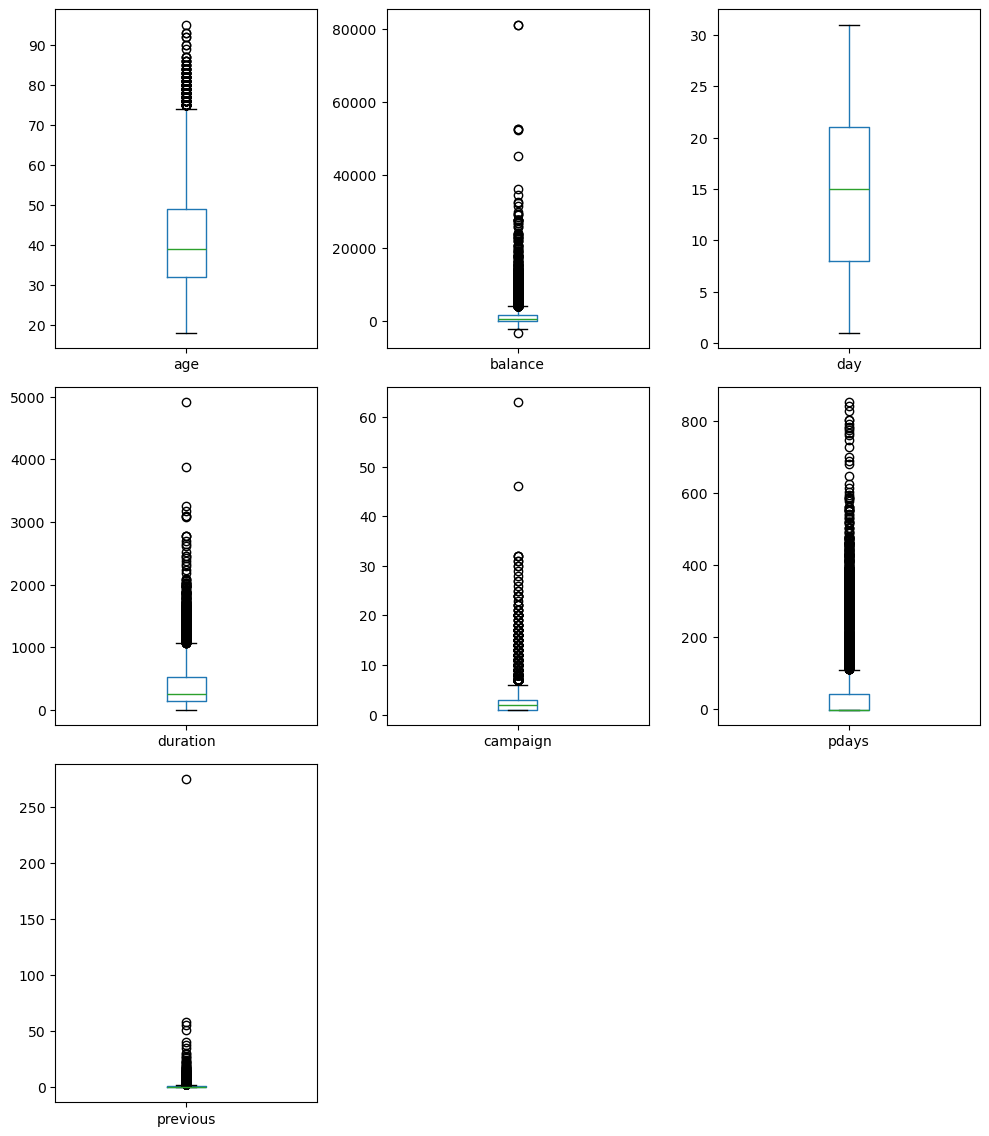

In [34]:
#Check for outliers 

cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous']

        
plt.figure(figsize=(10,15))

for i, col in enumerate(cols):
    plt.subplot(4,3,i+1)
    df.boxplot(col)
    plt.grid()
    plt.tight_layout()


def check_outliers(df, delimiter=';'):
    df = pd.read_csv('bank_balanced.csv', delimiter=delimiter)

    def find_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series < lower_bound) | (series > upper_bound)]

    for column in df.select_dtypes(include=[np.number]).columns:
        outliers = find_outliers(df[column])
        if not outliers.empty:
            print(f"\nOutliers in column '{column}':")
            print(f"Number of outliers: {len(outliers)}")
            print(f"Percentage of outliers: {(len(outliers) / len(df[column])) * 100:.2f}%")

check_outliers('bank_balanced.csv')


In [15]:
#Fix outliers 

#Impute the mean to diminish outliers
def impute_outliers(df):
    for column in ["balance","campaign", "duration", "pdays", "previous"]:
        if column == "pdays":
            valid_data = df[df[column] != -1][column]
        elif column == "previous":
            valid_data = df[df[column] != 0][column]
        else:
            valid_data = df[column]

        mean = valid_data.mean()
        std = valid_data.std()
        lower_limit = mean - std
        upper_limit = mean + std

        # Only impute values that are not -1 for pdays or 0 for previous
        if column == "pdays":
            df.loc[(df[column] < lower_limit) & (df[column] != -1), column] = mean
            df.loc[(df[column] > upper_limit) & (df[column] != -1), column] = mean
        elif column == "previous":
            df.loc[(df[column] < lower_limit) & (df[column] != 0), column] = mean
            df.loc[(df[column] > upper_limit) & (df[column] != 0), column] = mean
        else:
            df.loc[df[column] < lower_limit, column] = mean
            df.loc[df[column] > upper_limit, column] = mean

    return df

# Impute outliers
df_imputed = impute_outliers(df)

def check_outliers(df):
    def find_outliers(series, ignore_value=None):
        if ignore_value is not None:
            series = series[series != ignore_value]
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series < lower_bound) | (series > upper_bound)]

    for column in df.select_dtypes(include=[np.number]).columns:
        if column == "pdays":
            outliers = find_outliers(df[column], ignore_value=-1)
        elif column == "previous":
            outliers = find_outliers(df[column], ignore_value=0)
        else:
            outliers = find_outliers(df[column])

        print(f"\nOutliers in column '{column}':")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {(len(outliers) / len(df[column])) * 100:.2f}%")

df = pd.read_csv('bank_balanced.csv', delimiter=';')

print("Check outliers for original df & imputed df: ")
check_outliers(df)
print('-------------------------')
check_outliers(df_imputed)

Check outliers for original df & imputed df: 

Outliers in column 'age':
Number of outliers: 162
Percentage of outliers: 1.53%

Outliers in column 'balance':
Number of outliers: 1019
Percentage of outliers: 9.63%

Outliers in column 'day':
Number of outliers: 0
Percentage of outliers: 0.00%

Outliers in column 'duration':
Number of outliers: 559
Percentage of outliers: 5.28%

Outliers in column 'campaign':
Number of outliers: 551
Percentage of outliers: 5.21%

Outliers in column 'pdays':
Number of outliers: 26
Percentage of outliers: 0.25%

Outliers in column 'previous':
Number of outliers: 153
Percentage of outliers: 1.45%
-------------------------

Outliers in column 'age':
Number of outliers: 162
Percentage of outliers: 1.53%

Outliers in column 'balance':
Number of outliers: 327
Percentage of outliers: 3.09%

Outliers in column 'day':
Number of outliers: 0
Percentage of outliers: 0.00%

Outliers in column 'duration':
Number of outliers: 39
Percentage of outliers: 0.37%

Outliers in

C:\Users\sophi\AppData\Local\Temp\ipykernel_13848\828538275.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1528.3433541312156' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column] < lower_limit, column] = mean
C:\Users\sophi\AppData\Local\Temp\ipykernel_13848\828538275.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.4938551711098507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column] < lower_limit, column] = mean
C:\Users\sophi\AppData\Local\Temp\ipykernel_13848\828538275.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '380.883059179429' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

In [30]:
#Skewness in numerical columns

def check_skewness(df_imputed, printing=True):
    highly_skewed_columns = []
    def interpret_skewness(sk):
        if sk < -1:
            return "Highly Negatively Skewed"
        elif -1 <= sk < -0.5:
            return "Moderately Negatively Skewed"
        elif -0.5 <= sk < 0:
            return "Approximately Symmetric (Slightly Negative)"
        elif sk == 0:
            return "Perfectly Symmetric"
        elif 0 < sk < 0.5:
            return "Approximately Symmetric (Slightly Positive)"
        elif 0.5 <= sk < 1:
            return "Moderately Positively Skewed"
        else:
            return "Highly Positively Skewed"

# Check each numeric column for skewness
    for column in df_imputed.select_dtypes(include=[np.number]).columns:
        sk = skew(df_imputed[column].dropna())
        interpretation = interpret_skewness(sk)
        if printing:
            print(f"\nColumn: {column}")
            print(f"Skewness: {sk:.4f}")
            print(f"Interpretation: {interpretation}")
        if abs(sk) > 1:
            highly_skewed_columns.append(column)

    return highly_skewed_columns

# Usage
check_skewness(df_imputed)


Column: age
Skewness: 0.8543
Interpretation: Moderately Positively Skewed

Column: balance
Skewness: 1.2773
Interpretation: Highly Positively Skewed

Column: day
Skewness: 0.1323
Interpretation: Approximately Symmetric (Slightly Positive)

Column: duration
Skewness: 0.5673
Interpretation: Moderately Positively Skewed

Column: campaign
Skewness: 1.0514
Interpretation: Highly Positively Skewed

Column: pdays
Skewness: 1.5296
Interpretation: Highly Positively Skewed

Column: previous
Skewness: 2.6859
Interpretation: Highly Positively Skewed

Column: y
Skewness: 0.0000
Interpretation: Perfectly Symmetric


['balance', 'campaign', 'pdays', 'previous']

In [37]:
def apply_log_transformations(df_imputed, log_columns):
    df_transformed = df_imputed.copy()

    for col in log_columns:
        if col in df_transformed.columns:
            min_value = df_transformed[col].min()
            if min_value <= 0:
                df_transformed[col] = df_transformed[col] - min_value + 1
            df_transformed[col] = np.log1p(df_transformed[col])

    return df_transformed
    
log_columns = check_skewness(df_imputed, printing=False)
prev_len = 0
while len(log_columns) != prev_len:
    prev_len = len(log_columns)
    df = apply_log_transformations(df_imputed, check_skewness(df_imputed, printing=False))
    log_columns = check_skewness(df_imputed, printing=False)
check_skewness(df)


Column: age
Skewness: 0.8543
Interpretation: Moderately Positively Skewed

Column: balance
Skewness: -0.4031
Interpretation: Approximately Symmetric (Slightly Negative)

Column: day
Skewness: 0.1323
Interpretation: Approximately Symmetric (Slightly Positive)

Column: duration
Skewness: 0.5673
Interpretation: Moderately Positively Skewed

Column: campaign
Skewness: 0.5059
Interpretation: Moderately Positively Skewed

Column: pdays
Skewness: 1.1436
Interpretation: Highly Positively Skewed

Column: previous
Skewness: 1.8528
Interpretation: Highly Positively Skewed

Column: y
Skewness: 0.0000
Interpretation: Perfectly Symmetric


['pdays', 'previous']

In [39]:
# Select features (excluding target variable)
X = df.drop(columns=['y'])
y = df['y']

In [40]:
# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [41]:
# Split dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
# Initialize models
logistic_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

In [49]:
# Fit models
logistic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [50]:
# Predict on test data
logistic_preds = logistic_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

In [51]:
# Evaluate models
logistic_acc = accuracy_score(y_test, logistic_preds)
rf_acc = accuracy_score(y_test, rf_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)

In [52]:
logistic_acc, rf_acc, xgb_acc

(0.7878071833648393, 0.8374291115311909, 0.8501890359168242)